# <center>Scaling XGBoost Hyper-Parameter Optimization</center>

<img src="images/swarm.png" width="400"/>

# Motivation:

To reach highest performance in classification tasks (i.e., supervised learning ), it is best practice to build an ensemble of champion models. 

Each member of the ensemble is a winner of a search over many models of its kind with altered hyper-parameters.

In this notebook, we build a harness for running such a [hyper-parameter] search to demonstrate the accuracy benefits while exploring performance as we scale within and accross GPU nodes.

# Library Imports:

In [11]:
import ipyvolume as ipv
import matplotlib.pyplot as plt

import numpy as np; import pandas as pd; import cudf
import cuml; import xgboost; from xgboost import plot_tree

import warnings; warnings.filterwarnings('ignore')
import time; import copy 

import data_utils
import swarm
import visualization as viz

# reload library modules/code without a kernel restart
import importlib; importlib.reload( swarm ); importlib.reload( data_utils ); importlib.reload( viz);

# Dataset:

<center> In this notebook you can try different hyper-parameter search methods using synthetic or real data. </center>


<img src="images/datasets.png" width="800"/>

# Data Ingestion / Generation

In [2]:
%%time
# dataset = data_utils.Dataset( 'fashion-mnist')
# dataset = data_utils.Dataset( 'airline', nSamples = 1000000)
# dataset = data_utils.Dataset( 'synthetic', coilType = 'helix', coilDensity = 9, nSamples = 5000000)
dataset = data_utils.Dataset( 'synthetic', coilType = 'whirl', coilDensity = 18, nSamples = 5000000)

CPU times: user 2.1 s, sys: 914 ms, total: 3.02 s
Wall time: 3.11 s


# Data Splitting

**Objective**: As is typical in machine learning workflows we need to split the dataset into a **train-set** and **test-set**. The test-set is unseen during training and model performance on the test-set is an indicator of how well our model(s) can generalize to future data [ also unseen during training ].


> **Note**: In the case of synthetic data, we use a non-standard way of splitting the dataset in order to increase the difficulty of the problem and make it a challenge worthy of HPO. Specifically, we carve out the middle of the dataset along one of the synthetic dimensions [ x ], and assign these points to the test-set.

In [3]:
percentTrain = .75
if dataset.datasetName != 'synthetic':    
    trainData, testData, trainLabels, testLabels = cuml.train_test_split( dataset.data, dataset.labels, train_size = .75 )
    
else:    
    # samples to exchange between train and test set [ enables generalization in the synthetic data case ]
    samplesToSwap = int( dataset.data.shape[0] * .002 ) 
    # in the case of the helix increase the amount of training data since its a 
    if dataset.coilType == 'helix': percentTrain = .885 
    trainData, testData, trainLabels, testLabels = data_utils.split_synthetic ( dataset.data, dataset.labels, 
                                                                                percentTrain = percentTrain, 
                                                                                samplesToSwap = samplesToSwap )

dataset.assign_dataset_splits ( trainData, testData, trainLabels, testLabels )

splitting synthetic dataset into train-set 75.0% and test-set 25.0%
> assigning middle span of data to test-set
> swapping 10000 samples between train-set and test-set


# Data Transformation

**Objective**: Apply standard scaling to each feature column of the dataset to ensure the data is numerically centered and ready for ingestion by an upstream model.
**Note**: This is an inplace operation which changes the value of the argument dataframe passed in without returning a value.

>More formally this transformation attempts to create normally distributed data features with 0 mean and unit variance.
This is accomplished by computing the means and standard deviations of each column in the train-set, and applying these statistics to normalize both the train and test sets.

> <font size="5">$x_{rescaled} = \frac{ x - \mu_{train} }{\sigma_{train}}$</font>

In [4]:
# before scaling
data_utils.print_stats( dataset )

                   x        y        z
  train means  :  27.916    0.000    0.000
  train stDevs :  18.782    7.764    7.679

  test  means  :  29.302   -0.001    0.001
  test  stDevs :   4.526    4.398    4.643


In [5]:
# apply standard scaling inplace to train-set and test-set
trainMeans, trainSTDevs, _ = data_utils.scale_dataframe_inplace ( dataset.trainData, label='train-set', datasetObject = dataset )
_,_,_ = data_utils.scale_dataframe_inplace ( dataset.testData, trainMeans, trainSTDevs, label='test-set', datasetObject = dataset )

applying [inplace] standard scaling to train-set data
applying [inplace] standard scaling to test-set data


In [6]:
# after scaling
data_utils.print_stats( dataset )

                   x        y        z
  train means  :   0.000    0.000    0.000
  train stDevs :   1.000    1.000    1.000

  test  means  :   0.074   -0.000    0.000
  test  stDevs :   0.241    0.566    0.605


# Data Visualization 

**Objective**: Build intuition and validate

## Plot the dataset in its raw form [ no re-scaling ]

In [7]:
viz.plot_data( dataset.data, dataset.labels, dataset.datasetName )

plotting SYNTHETIC dataset, original shape: (5000000, 3)
 > plotting subset of 100000 samples -- 2.00% of total, adjust via maxSamplesToPlot 


## Visualize Train vs Test [ after split & rescaling ]

In [12]:
viz.plot_train_vs_test(dataset)

visualizing using train decimation factor: 148, test decimation factor: 50


# Manual Hyper-Parameter Choice [ a.k.a., Can you beat HPO? ]

In [13]:
# flexible parameters -- read more @ https://xgboost.readthedocs.io/en/latest/parameter.html

manualXGBoostParams = { 
    'max_depth': 6,                     # default = 6             :: maximum depth of a tree
    'num_boost_round': 50,              # default = XXX           :: number of trees        
    'learning_rate': 0.3,               # default = 0.3           :: step size shrinkage between rounds, prevents overfitting
    'gamma': 0.,                        # default = 0             :: minimum loss reduction required to make a leaf node split, prevents overfitting
    'lambda': 1.,                       # default = 1             :: L2 regularizaiton term on weights, prevents overfitting
    'alpha': 0.,                        # default = 0             :: L1 regularization term on weights, prevents overfitting
    'tree_method': 'gpu_hist',          # default = 'gpu_hist'    :: tree construction algorithm
}

> note that we'll inherit objective function from the dataset

In [14]:
swarm.evaluate_manual_params( dataset, manualXGBoostParams )

train accuracy : 0.930 
test accuracy  : 0.564 
trained in 0.68 seconds

parameter settings:

{    'alpha': 0.0,
     'gamma': 0.0,
     'lambda': 1.0,
     'learning_rate': 0.3,
     'max_depth': 6,
     'num_boost_round': 50,
     'objective': 'binary:hinge',
     'tree_method': 'gpu_hist'}


# Define Compute Cluster

In [15]:
import dask
from dask import delayed
from dask_cuda import LocalCUDACluster

from dask.distributed import Client
from dask.distributed import as_completed
from dask.distributed import worker

In [16]:
cluster = LocalCUDACluster( ip = '', n_workers = 4)

In [17]:
client = Client( cluster, asynchronous = True)

In [18]:
client

Client Scheduler: tcp://172.17.0.3:33279 Dashboard: http://172.17.0.3:8787/status,Cluster Workers: 4 Cores: 4 Memory: 270.39 GB


# Define HPO XGBoost Search Ranges

> **Note**: number of trees will be allowed to freely range between 0-2000 with an early stopping settting of 250

In [19]:
paramRanges = { 0: ['max_depth', 2, 15, 'int'],
                1: ['learning_rate', .001, 2, 'float'],
                2: ['gamma', 0., 3., 'float'] }

# Search Strategies

&nbsp;

| method name | &nbsp;&nbsp;&nbsp; performance | &nbsp;&nbsp;&nbsp; search duration  |
|-----------------------|-----------------|------------------|
| random-search         | &nbsp;&nbsp;&nbsp; worst | &nbsp;&nbsp;&nbsp; slow    |
| particle-search [1]      | &nbsp;&nbsp;&nbsp; good  | &nbsp;&nbsp;&nbsp; fast    |
| async-particle-search | &nbsp;&nbsp;&nbsp; best  | &nbsp;&nbsp;&nbsp; fastest |

<center>[1] https://en.wikipedia.org/wiki/Particle_swarm_optimization#Algorithm</center>

# HPO Search Strategy : Particle Swarm, Random Search, Grid Search
# Sync vs Async [ Dask Task Stream ]

<img src='images/sync_vs_async.png' width='1000px'>

# Key Params [ nParticles & nEpochs ]

# Monitoring Perf [ <- ]
You'll have need to have launched the container w Port Open
Connect via [ the http:// is important]

# Run HPO - <font color = '#ffb500'> Synchronous Swarm </font>

In [20]:
syncSwarm = swarm.SyncSwarm( client, dataset, paramRanges, nParticles = 10, nEpochs = 8 )

! initializing SyncSwarm, with 10 particles, and 8 epochs


In [21]:
syncSwarm.run_search()

0,[2.e+00 1.e-03 0.e+00],[2.41396007 1.43106658 0.74138218]
1,[7.         1.86518216 2.99712155],[12.92680508 -1.48675846 -1.58346614]
2,[10.          1.86315019  1.45424729],[-8.18786597  1.79002698 -1.07678138]
3,[12.          1.68005814  1.70793398],[-11.16115312  -1.51392833  -0.37762835]
4,[12.          0.34621797  1.8271068 ],[10.41615784  1.42177255  0.58533723]
5,[5.         1.66282434 2.938335  ],[-11.56531678  -0.54477989  -2.46107377]
6,[12.          0.41960333  1.11032821],[11.63437799 -1.74211009  2.91017289]
7,[6.         0.87738005 2.93396854],[7.2778886  0.89341378 0.23097522]
8,[5.         0.47963971 2.44938385],[-12.71102454  -0.48968714  -0.46589519]
9,[15.  2.  3.],[ 0.0487394  -1.46394954 -1.68864795]
new best 0.50000 found by particle 0 on eval 0
new best 0.94346 found by particle 1 on eval 1
new best 0.94379 found by particle 2 on eval 2
new best 0.94419 found by particle 3 on eval 3
new best 0.95441 found by particle 4 on eval 4
> sync epoch 0 of 8
> sync epoch 

## Visualize <font color='#ffb500'> Synchronous Swarm </font>

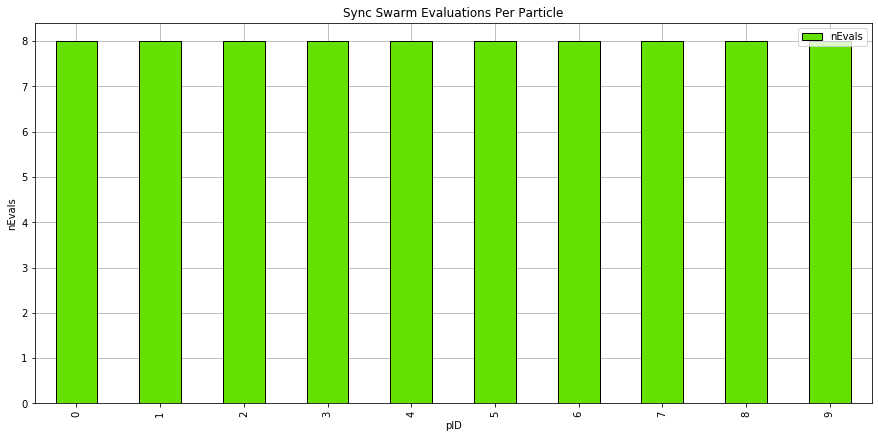

In [22]:
viz.plot_particle_evals( syncSwarm )

In [23]:
viz.viz_particle_trails( syncSwarm, topN = 3 )

elapsed time 0.69


In [24]:
viz.viz_swarm( syncSwarm, syncSwarm.paramRanges)

# Run HPO - <font color='#7400ff'> Asynchronous Swarm </font>

In [ ]:
asyncSwarm = swarm.AsyncSwarm( client, dataset, paramRanges, nParticles = 10, nEpochs = 8 )

In [ ]:
asyncSwarm.run_search( syncWarmupFlag = True )

## Visualize <font color='#7400ff'> Asynchronous Swarm </font>

In [ ]:
viz.plot_particle_evals( asyncSwarm )

In [ ]:
viz.viz_particle_trails( asyncSwarm, topN = 1 )

In [ ]:
viz.viz_swarm( asyncSwarm, asyncSwarm.paramRanges )

# Run HPO - <font color='#666666'> Random Search </font>

In [ ]:
randomAsyncSwarm = swarm.RandomSearchAsync ( client, dataset, paramRanges, nParticles = 8, nEpochs = 5 )

In [ ]:
randomAsyncSwarm.run_search()

## Visualize <font color='#666666'> Random Swarm </font>

In [ ]:
viz.plot_particle_evals( randomAsyncSwarm )

In [ ]:
viz.viz_particle_trails( randomAsyncSwarm, topN = 0 )

In [ ]:
viz.viz_swarm( randomAsyncSwarm, randomAsyncSwarm.paramRanges )

# Determine best swarm

In [ ]:
if syncSwarm.globalBest['accuracy'] > asyncSwarm.globalBest['accuracy']:
    swarm = syncSwarm
else:
    swarm = asyncSwarm

# Train XGBoost model with best params

In [ ]:
bestParams = {
    'tree_method': 'gpu_hist',
    'random_state': 0, 
    'max_depth': int(swarm.globalBest['params'][0]),
    'learning_rate': swarm.globalBest['params'][1],
    'gamma': swarm.globalBest['params'][2]
}
    
bestParams['objective'] = dataset.trainObjective[0]
if dataset.trainObjective[1] is not None: 
    bestParams['num_class'] = dataset.trainObjective[1]

In [ ]:
%%time
trainDMatrix = xgboost.DMatrix( data = dataset.trainData, label = dataset.trainLabels )
testDMatrix = xgboost.DMatrix( data = dataset.testData, label = dataset.testLabels )
trainedModelGPU = xgboost.train( dtrain = trainDMatrix, evals = [(testDMatrix, 'test')], params = bestParams,
                                 num_boost_round = swarm.globalBest['nTrees'], verbose_eval=False)

In [ ]:
# save best model
trainedModelGPU.save_model('xgb.model.hpo')

In [ ]:
from cuml import ForestInference

In [ ]:
fm = ForestInference.load( filename='xgb.model.hpo')

In [ ]:
fm = ForestInference.load( filename='xgb.model.hpo',
                           algo='BATCH_TREE_REORG',
                           output_class=True,
                           threshold=0,
                           model_type='xgboost' )

In [ ]:
type( dataset.testData )

In [ ]:
test = dataset.testData.as_gpu_matrix(order='C')

In [ ]:
for iColumn in dataset.testData.columns:    
    dataset.testData[iColumn] = dataset.testData[iColumn].astype('float32')

In [ ]:
dataset.testData.dtypes

In [ ]:
%%time
trainedModelGPU.predict( testDMatrix )

In [ ]:
%%time
filPredictions = fm.predict ( dataset.testData, 
                              algo='BATCH_TREE_REORG', 
                              output_class=True, 
                              threshold=0, 
                              model_type='xgboost' )

In [ ]:
cudf.Series(filPredictions)

In [ ]:
%%time
# perform prediction on the model loaded from path
fil_preds = fm.predict()

# Inference with trained model on test data

In [ ]:
%%time
predictions = trainedModelGPU.eval(testDMatrix)

In [ ]:
testDataPerf = 1 - float( predictions.split(':')[1] )
print(f'accuracy: {testDataPerf}')

# Summary

# Scale Up Results [ DGX-2 ]

<img src='images/synthetic_async.png'></img>

Async Scaling > Sync Scaling > Random Search

# References

# Future Work / Extensions

larger than single GPU memory datasets - dask_cudf + [ dask_xgboost or xgboost.dask ]

1. [ Generate a classification dataset on GPU ](#data-load) (e.g., double helix, unwinding helix/whirl )

2. [ ETL - process/prepare data for model training ](#ETL) (e.g., scale, split, augment )   
    
3. [ Define HPO Strategy ](#define-hpo)

4. [ Create Compute Cluster ](#compute-cluster)
   > LocalCUDACluster or KubeCluster
      
5. [ Define Seach ](#define-search)

6. [ Run ASYNC Particle Swarm ](#run-async-PSO)

7. [ Run Classic Particle Swarm ](#run-classic-PSO)

8. [ Run Random Search Baseline ](#run-random-search)

9. [ Summary ](#summary)

# User Choices:

The user is able to make several key choices in running this notebook. They are as follows:

1. [ Dataset ]()
2. [ Compute Scaling Strategy - Scale-Up, Scale-Out ]()
3. [ XGBoost Parameter Search Range ]()

4. [ Particle Swarm Type ]()
   * Synchronous
   * Asynchronous
   * Random Search